In [1]:
import numpy as np
import pandas as pd

from nixtla.data.datasets.epf import EPF, EPFInfo
from nixtla.experiments.utils import hyperopt_tunning, evaluate_model
from nixtla.losses.numpy import mae, mape, smape, rmse, pinball_loss

from hyperopt import fmin, tpe, hp, Trials, STATUS_OK

import matplotlib.pyplot as plt

# DATA

In [2]:
dataset = ['NP']

Y_df, X_df, S_df = EPF.load_groups(directory='../data', groups=dataset)

# Train and validation
Y_df = Y_df.head(24*365)
X_df = X_df.head(24*365)

# Full set (with one more week)
len_test = 7*24
Y_test_df = Y_df.head(24*365 + len_test)
X_test_df = X_df.head(24*365 + len_test)

# SPACE

In [3]:
# # NBEATS
# space= {# Architecture parameters
#         'model':'nbeats',
#         'input_size_multiplier': hp.choice('input_size_multiplier', [7]),
#         'output_size': hp.choice('output_size', [24]),
#         'shared_weights': hp.choice('shared_weights', [False]),
#         'activation': hp.choice('activation', ['selu']),
#         'initialization':  hp.choice('initialization', ['glorot_normal','he_normal']),
#         'stack_types': hp.choice('stack_types', [2*['identity'],
#                                                     1*['identity']+1*['exogenous_tcn'],
#                                                     1*['exogenous_tcn']+1*['identity'] ]),
#         'n_blocks': hp.choice('n_blocks', [ [1, 1] ]),
#         'n_layers': hp.choice('n_layers', [ [2, 2] ]),
#         'n_hidden': hp.choice('n_hidden', [ 364 ]),
#         'n_harmonics': hp.choice('n_harmonics', [1]),
#         'n_polynomials': hp.choice('n_polynomials', [2]),
#         'exogenous_n_channels': hp.quniform('exogenous_n_channels', 1, 10, 1),
#         'x_s_n_hidden': hp.choice('x_s_n_hidden', [0]),
#         # Regularization and optimization parameters
#         'batch_normalization': hp.choice('batch_normalization', [False]),
#         'dropout_prob_theta': hp.uniform('dropout_prob_theta', 0, 0.5),
#         'dropout_prob_exogenous': hp.uniform('dropout_prob_exogenous', 0, 0.5),
#         'learning_rate': hp.loguniform('learning_rate', np.log(5e-4), np.log(0.001)),
#         'lr_decay': hp.uniform('lr_decay', 0.3, 0.5),
#         'n_lr_decay_steps': hp.choice('n_lr_decay_steps', [3]),
#         'weight_decay': hp.loguniform('weight_decay', np.log(5e-5), np.log(5e-3)),
#         'n_iterations': hp.choice('n_iterations', [100]), #[args.max_epochs]),
#         'early_stopping': hp.choice('early_stopping', [16]),
#         'eval_freq': hp.choice('eval_freq', [50]),
#         'loss': hp.choice('loss', ['MAE']),
#         'loss_hypar': hp.choice('loss_hypar', [0.5]),                
#         'val_loss': hp.choice('val_loss', ['MAE']), #[args.val_loss]),
#         'l1_theta': hp.choice('l1_theta', [0]),
#         # Data parameters
#         'normalizer_y': hp.choice('normalizer_y', [None]),
#         'normalizer_x': hp.choice('normalizer_x', ['median']),
#         'window_sampling_limit': hp.choice('window_sampling_limit', [50_000]),
#         'complete_inputs': hp.choice('complete_inputs', [False]),                
#         'complete_sample': hp.choice('complete_sample', [False]),                
#         'frequency': hp.choice('frequency', ['H']),
#         'seasonality': hp.choice('seasonality', [24]),      
#         'idx_to_sample_freq': hp.choice('idx_to_sample_freq', [24]),
#         'val_idx_to_sample_freq': hp.choice('val_idx_to_sample_freq', [24]),
#         'batch_size': hp.choice('batch_size', [256]),
#         'n_series_per_batch': hp.choice('n_series_per_batch', [1]),
#         'random_seed': hp.quniform('random_seed', 10, 20, 1)}

In [4]:
#ESRNN
space = {'model': hp.choice('model', ['esrnn']),
         # ARCHITECTURE
         'es_component': hp.choice('es_component', ['multiplicative']),
         'cell_type': hp.choice('cell_type', ['LSTM']),
         'state_hsize': hp.quniform('state_hsize', 5, 100, 5),
         'dilations': hp.choice('dilations', [ [[1, 24]], [[1, 4, 24, 168]], [[1, 4], [24, 168]] ]),
         'add_nl_layer': hp.choice('add_nl_layer', [True, False]),
         'rnn_weight_decay': hp.choice('rnn_weight_decay', [0, 0.0005, 0.005]),
         # OPTIMIZATION
         'loss': hp.choice('loss', ['SMYL']),
         'max_epochs': hp.choice('max_epochs', [20]),
         'eval_freq': hp.choice('eval_freq', [1]),
         'batch_size': hp.choice('batch_size', [1]),
         'n_series_per_batch': hp.choice('n_series_per_batch', [1]),
         'idx_to_sample_freq': hp.choice('idx_to_sample_freq', [24]),
         'val_idx_to_sample_freq': hp.choice('val_idx_to_sample_freq', [24]),
         'learning_rate': hp.loguniform('learning_rate', np.log(5e-4), np.log(0.3)),
         'lr_scheduler_step_size': hp.choice('lr_scheduler_step_size', [30, 50, 100]),
         'lr_decay': hp.quniform('lr_decay', 0.5, 1.0, 0.1),
         'per_series_lr_multip': hp.choice('per_series_lr_multip', [0.5, 1.0, 1.5, 2.0, 3.0]),
         'gradient_eps': hp.choice('gradient_eps', [1e-8]),
         'gradient_clipping_threshold': hp.choice('gradient_clipping_threshold', [10, 50]),
         'noise_std': hp.loguniform('noise_std', np.log(0.0001), np.log(0.01)),
         'level_variability_penalty': hp.quniform('level_variability_penalty', 0, 200, 5),
         'testing_percentile': hp.choice('testing_percentile', [50]),
         'training_percentile': hp.choice('training_percentile', [48, 49, 50, 51]),
         # DATA
         'input_size_multiplier': hp.choice('input_size_multiplier', [2]),
         'output_size': hp.choice('output_size', [24]),
         'window_sampling_limit': hp.choice('window_sampling_limit', [24*180]),
         'normalizer_y': hp.choice('normalizer_y', [None]),
         'normalizer_x': hp.choice('normalizer_x', ['norm', 'norm1', 'std', 'median', 'invariant']),
         'complete_inputs': hp.choice('complete_inputs', [True]),
         'complete_sample': hp.choice('complete_sample', [False]),
         'seasonality': hp.choice('seasonality', [ [24], [24, 168] ]), 
         'random_seed': hp.quniform('random_seed', 1, 1000, 1)}

In [5]:
# # RNN
# space = {'model': hp.choice('model', ['rnn']),
#          # ARCHITECTURE
#          'cell_type': hp.choice('cell_type', ['LSTM']),
#          'state_hsize': hp.quniform('state_hsize', 5, 100, 5),
#          'dilations': hp.choice('dilations', [ [[1, 24]], [[1, 4, 24, 168]], [[1, 4], [24, 168]] ]),
#          'add_nl_layer': hp.choice('add_nl_layer', [True, False]),
#          'rnn_weight_decay': hp.choice('rnn_weight_decay', [0, 0.0005, 0.005]),
#          # OPTIMIZATION
#          'loss': hp.choice('loss', ['MAE']),
#          'max_epochs': hp.choice('max_epochs', [100]),
#          'eval_freq': hp.choice('eval_freq', [10]),
#          'batch_size': hp.choice('batch_size', [1]),
#          'n_series_per_batch': hp.choice('n_series_per_batch', [1]),
#          'idx_to_sample_freq': hp.choice('idx_to_sample_freq', [24]),
#          'val_idx_to_sample_freq': hp.choice('val_idx_to_sample_freq', [24]),
#          'learning_rate': hp.loguniform('learning_rate', np.log(5e-4), np.log(0.3)),
#          'lr_scheduler_step_size': hp.choice('lr_scheduler_step_size', [30, 50, 100]),
#          'lr_decay': hp.quniform('lr_decay', 0.5, 1.0, 0.1),
#          'gradient_eps': hp.choice('gradient_eps', [1e-8]),
#          'gradient_clipping_threshold': hp.choice('gradient_clipping_threshold', [10, 50]),
#          'noise_std': hp.loguniform('noise_std', np.log(0.0001), np.log(0.01)),
#          'testing_percentile': hp.choice('testing_percentile', [50]),
#          'training_percentile': hp.choice('training_percentile', [48, 49, 50, 51]),
#          # DATA
#          'input_size_multiplier': hp.choice('input_size_multiplier', [2]),
#          'output_size': hp.choice('output_size', [24]),
#          'window_sampling_limit': hp.choice('window_sampling_limit', [24*180]),
#          'normalizer_y': hp.choice('normalizer_y', [None]),
#          'normalizer_x': hp.choice('normalizer_x', ['norm', 'norm1', 'std', 'median', 'invariant']),
#          'complete_inputs': hp.choice('complete_inputs', [True]),
#          'complete_sample': hp.choice('complete_sample', [False]),
#          'random_seed': hp.quniform('random_seed', 1, 1000, 1)}

In [6]:
# # TCN
# space= {# Architecture parameters
#         'model':'tcn',
#         'input_size_multiplier': hp.choice('input_size_multiplier', [7]),
#         'output_size': hp.choice('output_size', [24]),
#         'initialization':  hp.choice('initialization', ['glorot_normal','he_normal']),
#         'kernel_size': hp.choice('kernel_size', [2, 3, 4] ),
#         'n_channels': hp.choice('n_channels', [ [1, 1, 1, 1], [5, 5, 5, 5] ]),
#         # Regularization and optimization parameters
#         'dropout_prob': hp.uniform('dropout_prob', 0, 0.3),
#         'learning_rate': hp.loguniform('learning_rate', np.log(5e-4), np.log(0.001)),
#         'lr_decay': hp.uniform('lr_decay', 0.3, 0.5),
#         'n_lr_decay_steps': hp.choice('n_lr_decay_steps', [3]),
#         'weight_decay': hp.loguniform('weight_decay', np.log(5e-5), np.log(5e-3)),
#         'n_iterations': hp.choice('n_iterations', [1_000]),
#         'early_stopping': hp.choice('early_stopping', [10]),
#         'eval_freq': hp.choice('eval_freq', [50]),
#         'loss': hp.choice('loss', ['MAE']),
#         'loss_hypar': hp.choice('loss_hypar', [0.5]),                
#         'val_loss': hp.choice('val_loss', ['MAE']),
#         # Data parameters
#         'normalizer_y': hp.choice('normalizer_y', [None]),
#         'normalizer_x': hp.choice('normalizer_x', ['median']),
#         'window_sampling_limit': hp.choice('window_sampling_limit', [50_000]),
#         'complete_inputs': hp.choice('complete_inputs', [True]),
#         'complete_sample': hp.choice('complete_sample', [False]),                
#         'frequency': hp.choice('frequency', ['H']),
#         'seasonality': hp.choice('seasonality', [24]),      
#         'idx_to_sample_freq': hp.choice('idx_to_sample_freq', [24]),
#         'val_idx_to_sample_freq': hp.choice('val_idx_to_sample_freq', [24]),
#         'batch_size': hp.choice('batch_size', [256]),
#         'n_series_per_batch': hp.choice('n_series_per_batch', [1]),
#         'random_seed': hp.quniform('random_seed', 10, 20, 1)}

## TUNNING

In [7]:
# Performs hyperopt tunning, outputs results in trials object. timestamps_in_outsample is len of validation set
trials = hyperopt_tunning(space=space, hyperopt_iters=3, loss_function=mae, Y_df=Y_df, X_df=X_df, S_df=S_df,
                          timestamps_in_outsample=7*24, expected_fcds=7, shuffle_outsample=False)

  0%|          | 0/3 [00:00<?, ?trial/s, best loss=?]INFO:hyperopt.tpe:build_posterior_wrapper took 0.013552 seconds
INFO:hyperopt.tpe:TPE using 0 trials
Infered frequency: H
=============== Training ESRNN  ===============

Epoch: 0, Time: 1.544, Insample loss: 0.06988
Epoch: 1, Time: 3.205, Insample loss: 1.19252
Epoch: 2, Time: 4.853, Insample loss: 1.47867
Epoch: 3, Time: 6.482, Insample loss: 10.58629
Epoch: 4, Time: 8.140, Insample loss: 6.89224
Epoch: 5, Time: 9.778, Insample loss: 3.07203
Epoch: 6, Time: 11.391, Insample loss: 1.68526
Epoch: 7, Time: 12.982, Insample loss: 1.43379
Epoch: 8, Time: 14.698, Insample loss: 2.50468
Epoch: 9, Time: 16.379, Insample loss: 0.98908
Epoch: 10, Time: 18.136, Insample loss: 0.76750
Epoch: 11, Time: 19.722, Insample loss: 1.00267
Epoch: 12, Time: 21.155, Insample loss: 0.54626
Epoch: 13, Time: 22.668, Insample loss: 0.75368
Epoch: 14, Time: 23.908, Insample loss: 0.55181
Epoch: 15, Time: 25.270, Insample loss: 0.48707
Epoch: 16, Time: 26.556

### EXAMPLE of forecast in validation

In [8]:
y_true = trials.trials[0]['result']['y_true']
y_hat = trials.trials[0]['result']['y_hat']

14.238691

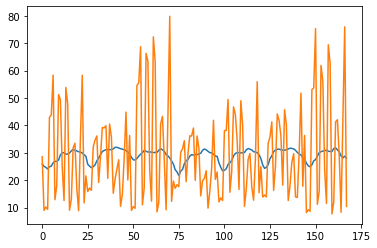

In [9]:
plt.plot(y_true.flatten())
plt.plot(y_hat.flatten())
mae(y_true,y_hat)

### Best mc

In [10]:
best_configuration = np.argmin(trials.losses())
best_mc = trials.trials[best_configuration]['result']['mc']

In [11]:
pd.Series(best_mc)

add_nl_layer                                 True
batch_size                                      1
cell_type                                    LSTM
complete_inputs                              True
complete_sample                             False
dilations                      ((1, 4, 24, 168),)
es_component                       multiplicative
eval_freq                                       1
gradient_clipping_threshold                    50
gradient_eps                                1e-08
idx_to_sample_freq                             24
input_size_multiplier                           2
learning_rate                         0.000635443
level_variability_penalty                      35
loss                                         SMYL
lr_decay                                      0.5
lr_scheduler_step_size                        100
max_epochs                                     20
model                                       esrnn
n_series_per_batch                              1


## PREDICT IN TEST

In [12]:
result = evaluate_model(loss_function=mae, mc=best_mc, Y_df=Y_test_df, X_df=X_test_df, S_df=S_df, timestamps_in_outsample=len_test,
                        expected_fcds=7, shuffle_outsample=False)

Infered frequency: H
=============== Training ESRNN  ===============

Epoch: 0, Time: 1.402, Insample loss: 0.05062
Epoch: 1, Time: 2.909, Insample loss: 0.04868
Epoch: 2, Time: 4.393, Insample loss: 0.04686
Epoch: 3, Time: 6.153, Insample loss: 0.04519
Epoch: 4, Time: 7.809, Insample loss: 0.04366
Epoch: 5, Time: 9.306, Insample loss: 0.04222
Epoch: 6, Time: 10.854, Insample loss: 0.04083
Epoch: 7, Time: 12.382, Insample loss: 0.03946
Epoch: 8, Time: 13.955, Insample loss: 0.03815
Epoch: 9, Time: 15.524, Insample loss: 0.03691
Epoch: 10, Time: 17.102, Insample loss: 0.03578
Epoch: 11, Time: 18.626, Insample loss: 0.03483
Epoch: 12, Time: 20.109, Insample loss: 0.03402
Epoch: 13, Time: 21.510, Insample loss: 0.03335
Epoch: 14, Time: 22.899, Insample loss: 0.03281
Epoch: 15, Time: 24.286, Insample loss: 0.03239
Epoch: 16, Time: 25.649, Insample loss: 0.03207
Epoch: 17, Time: 26.977, Insample loss: 0.03181
Epoch: 18, Time: 28.305, Insample loss: 0.03163
Epoch: 19, Time: 29.706, Insample 

1.2353894

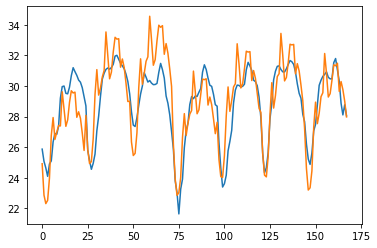

In [13]:
plt.plot(result['y_true'].flatten())
plt.plot(result['y_hat'].flatten())
mae(result['y_true'].flatten(), result['y_hat'].flatten())

In [14]:
Y_test_df

,unique_id,ds,y
0,NP,2013-01-01 00:00:00,31.05
1,NP,2013-01-01 01:00:00,30.47
2,NP,2013-01-01 02:00:00,28.92
3,NP,2013-01-01 03:00:00,27.88
4,NP,2013-01-01 04:00:00,26.96
...,...,...,...
8755,NP,2013-12-31 19:00:00,30.32
8756,NP,2013-12-31 20:00:00,28.87
8757,NP,2013-12-31 21:00:00,28.11
8758,NP,2013-12-31 22:00:00,28.77
